---
title: Project 1 - Train Model and Predict
author: Frederik Bennhoff
date: 2023-11-13
description: Train model and predict submission file for project 1.
---

# Fitting the model
Initial preprocessing steps are discussed in ```preproc.Rmd``` and associated output files. Taking the winsorized and preprocessed data, I have tried the following models: 
 - Ridge regression
 - Random Forest
 - Lasso regression
   - with cubic splines
   - without cubic splines

on datasets to which I applied the following additional transformations:
 - no transformation
 - quantile transformation
 - polynomial features

In general, I found that best results were produced by a LASSO regression with a quantile transformation. Outliers are mapped from the winsorized values to 0 and 1, and flagged by additional variables ```{varname}_{left/right}_out```. 

I fit the model using cross-validated LASSO. The hyperparameters are:
 - Hampel filter sensitivity, $g = 3$ (**fixed**)
 - LASSO regularization parameter, $\lambda$  (**cross validated**)

In [1]:
import os
os.chdir("../")

In [2]:
%run ./src/import_utils_load_data.py

## Model estimation

First, decide whether another transformation (e.g. a quantile transformation) should be applied.

In [3]:
additional_scaling = True # if true, additional scaling is applied to the features

Then split and transform data and fit the model using that transformation.

In [4]:
# Step 1: Split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=22)
y_val, y_train = np.ravel(y_val), np.ravel(y_train) # Flatten y_val and y_train

# Create scaled features
transformer = QuantileTransformer()
X_train_scaled = transformer.fit_transform(X_train)
X_val_scaled = transformer.transform(X_val)

# Which features to use?
if additional_scaling :
    X_train_data = X_train_scaled
    X_val_data = X_val_scaled
else :
    X_train_data = X_train
    X_val_data = X_val

# Step 2: Estimate a LASSO model
lasso_cv = LassoCV(alphas=np.logspace(-1.3, 0, 25), cv=10, random_state=10, max_iter=1000).fit(X_train_data, y_train)

Generate the typical LASSO cross-validation plot, in which the optimal $\lambda$ can be seen.

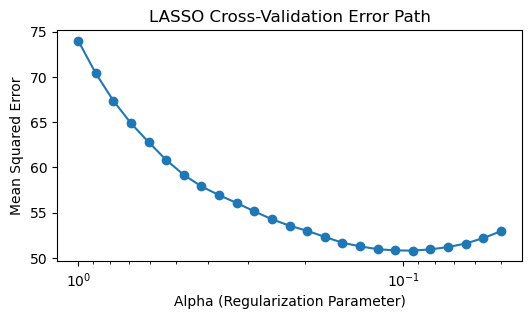

In [5]:
lasso_cv_error_path(lasso_cv) # Plotting the error path

## Model evaluation

Mean Squared Error on Validation Set: 40.18734610701192
R^2 on Validation Set: 0.5421570536188052


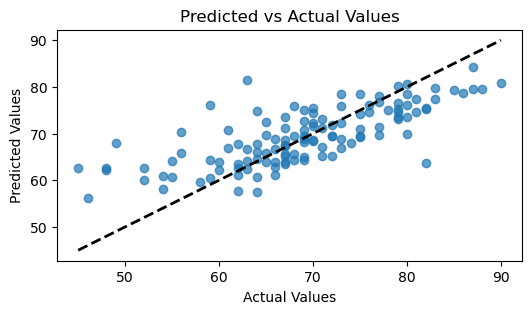

In [6]:
# Step 3: Validate the model
y_pred = lasso_cv.predict(X_val_data)

# plot the predicted vs actual values
validate_model(y_val, y_pred)

# print model coefficients into a file
model_print_results(X_train, lasso_cv, "lasso_coefficients")

# Predict on test sample
Using the fitted model, we predict the labels of the test sample.


In [7]:
α = lasso_cv.alpha_ # Best alpha value

# Create scaled features
transformer = QuantileTransformer()
X_train_full_scaled = transformer.fit_transform(X)
X_test_scaled = transformer.transform(X_test)

# Which features to use?
if additional_scaling :
    X_train_full = X_train_full_scaled
    X_test_data = X_test_scaled
else :
    X_train_full = X
    X_test_data = X_test

# Estimate LASSO model using the full training set
lasso = Lasso(alpha=α).fit(X_train_full, y)

# make model prediction
y_test_pred = lasso.predict(X_test_data)


In [8]:
pd.DataFrame({"id":np.array(ids), "y_pred":y_test_pred}).to_csv("out/lasso_prediction.csv", index=False)